# US Accidents
*EDA using a large file of US traffic accidents*

This notebook is intended to be run in an apache-sedona docker instance.
On starting an instance as described 
[here](https://sedona.apache.org/latest-snapshot/setup/docker/), 
run the following bash script to copy the data files across: 

```bash
    # Find the pid of the sedona instance.
    instance=$(docker ps | grep sedona | cut -d ' ' -f 1)

    # Assert that there is exactly one sedona instance running.
    n_instances=$(echo "$instance" | wc -l)
    if [ "$n_instances" -eq 0 ]; then
        echo "Error: No sedona instance running."
        exit 1
    elif [ "$n_instances" -gt 1 ]; then
        echo "Error: Multiple ($n_instances) sedona instances running."
        exit 1
    fi

    # Copy the data files accros.
    docker cp ./data $instance:/opt/workspace/
```

Otherwise the rest of this notebook assumes that a vanilla instance is running. 

In [1]:
%pip install seaborn
%pip install tabulate
%pip install plotly

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sedona.spark import SedonaContext
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.utils.adapter import Adapter
from sedona.maps.SedonaPyDeck import SedonaPyDeck as spdk
import pydeck as pdk


# Plotting defaults
sns.set_style("darkgrid")
sns.set_palette("muted")
colors = sns.color_palette()
plt.rcParams["figure.facecolor"] = "none"
plt.rcParams["figure.edgecolor"] = "none"
plt.rcParams["figure.figsize"] = (6, 6)

os.makedirs("figures", exist_ok=True)

## Set Up and Data Loading

### Spark/Sedona
We start by binding to a spark context to run the analysis.

In [3]:
config = (
    SedonaContext.builder()
    # Comment this out because the empty call causes a java NPE :/
    # .config(
    # )
    .getOrCreate()
)

sedona = SedonaContext.create(config)
sc = sedona.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/06 01:03:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Hello World (Load a Shapefile)
Test that we can interact with data, by 
1. Create an RDD from a shapefile on disk;
2. Convert to a spark dataframe;
3. Create a view of this dataframe;
4. Query the view with SQL syntax.

The state and county shapefiles come from [here](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html).

In [4]:
state_rdd = ShapefileReader.readToGeometryRDD(sc, os.path.join("data", "state"))
state_df = Adapter.toDf(state_rdd, sedona)
state_df.createOrReplaceTempView("states")

sedona.sql("""
select * from states
""").show(2)

+--------------------+-------+--------+-----------+-----+------+------------+----+------------+----------+
|            geometry|STATEFP| STATENS|    GEOIDFQ|GEOID|STUSPS|        NAME|LSAD|       ALAND|    AWATER|
+--------------------+-------+--------+-----------+-----+------+------------+----+------------+----------+
|POLYGON ((-109.05...|     35|00897535|0400000US35|   35|    NM|  New Mexico|  00|314198587197| 726463919|
|POLYGON ((-104.05...|     46|01785534|0400000US46|   46|    SD|South Dakota|  00|196341525171|3387709166|
+--------------------+-------+--------+-----------+-----+------+------------+----+------------+----------+
only showing top 2 rows



### Dump as a GeoDataFrame and Plot
The general workflow here will be to compute in spark, and only as a last step 
convert to (geo)Pandas for plotting/ final analysis.

In the next code cell we 
1. Make a simple query from the view defined above;
2. Convert it to a GeoDataFrame;
3. Convert the geometry to a Coordinate Reference System (CRS) that is more pleasant to look at;
4. Plot it.

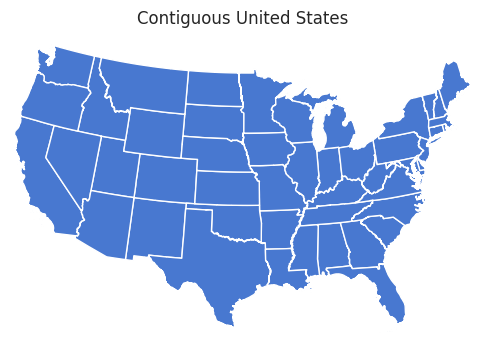

In [5]:
df = sedona.sql("""
select * from states 
""").toPandas()

gdf = gpd.GeoDataFrame(df, geometry=df["geometry"])
gdf = gdf.set_crs(4326)

fig, ax = plt.subplots()
ax.axis('off')
# Albers Equal Area projection for USA
gdf.to_crs(5070).plot(ax=ax)
ax.set(
    xlim=[-.24e7, .23e7], 
    ylim=[.2e6, 3.3e6], 
    xticks=[], 
    yticks=[], 
    title="Contiguous United States");

### Load Counties
We can also load and check the counties data by plotting Texas.

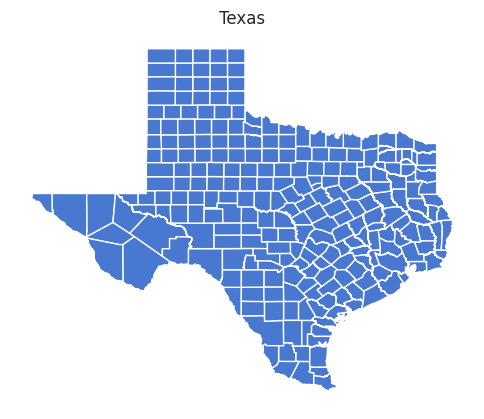

In [6]:
county_rdd = ShapefileReader.readToGeometryRDD(sc, os.path.join("data", "county"))
county_df = Adapter.toDf(county_rdd, sedona)
county_df.createOrReplaceTempView("counties")

fig, ax = plt.subplots()
ax.axis('off')

gpd.GeoDataFrame(sedona.sql("""
select * from counties
where STATE_NAME = "Texas"
""").toPandas(), geometry="geometry").plot(ax=ax);
ax.set(title="Texas");

### Load Accidents
This is a [kaggle dataset](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents).
Read the file and create a view that we can query with the SQL interface.
As above but reading a CSV not a shapefile.

In [7]:
accidents_df = (
    sedona.read.format("csv")
    .option("delimiter", ",")
    .option("header", "true")
    .load(os.path.join("data", "accidents", "US_Accidents_March23.csv"))
)

accidents_df = (
    accidents_df.withColumn("Start_Lat", accidents_df["Start_Lat"].cast("float"))
    .withColumn("Start_Lng", accidents_df["Start_Lng"].cast("float"))
    .withColumn("End_Lat", accidents_df["End_Lat"].cast("float"))
    .withColumn("End_Lng", accidents_df["End_Lng"].cast("float"))
    .withColumn("Severity", accidents_df["Severity"].cast("int"))
)

accidents_df.createOrReplaceTempView("accidents")
accidents_df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Start_Lat: float (nullable = true)
 |-- Start_Lng: float (nullable = true)
 |-- End_Lat: float (nullable = true)
 |-- End_Lng: float (nullable = true)
 |-- Distance(mi): string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: string (nullable = true)
 |-- Temperature(F): string (nullable = true)
 |-- Wind_Chill(F): string (nullable = true)
 |-- Humidity(%): string (nullable = true)
 |-- Pressure(in): string (nullable = true)
 |-- Visibility(mi)

24/12/06 01:03:42 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
# What day of december do Americans crash the most?
sedona.sql("""
    select count(*) as count, extract(day from start_time) as day
    from accidents
    where extract(month from start_time) = 12
      and extract(year from start_time) = 2020
    group by day
    order by count desc
    limit 4; 
""").show()

+-----+---+
|count|day|
+-----+---+
| 8013| 23|
| 7763| 24|
| 7497| 17|
| 7350| 30|
+-----+---+



In [9]:
# TODO
# Worst 4 days of the year for each severity level?
# https://stackoverflow.com/questions/2129693/restrict-results-to-top-n-rows-per-group

In [10]:
cencus_df = (
    sedona.read.format("csv")
    .option("delimiter", ",")
    .option("header", "true")
    .load(os.path.join("data", "cencus", "acs2015_census_tract_data.csv"))
)


for c in ["TotalPop", "Men", "Women", "Citizen", "Employed"]:
    cencus_df = cencus_df.withColumn(c, cencus_df[c].cast("int"))
# Select all counties in TX, join to accident counts. 
# Left join since some counties might have no accidents recorded.
# Plot with pydeck.  
for c in [
    "Hispanic", 
    "White", 
    "Black", 
    "Native", 
    "Asian", 
    "Pacific", 
    "Income",
    "IncomePerCap",
    "IncomePerCapErr",
    "Poverty",
    "ChildPoverty",
    "Professional", 
    "Service",
    "Office", 
    "Construction",
    "Production", 
    "Drive", 
    "Carpool", 
    "Transit", 
    "Walk", 
    "OtherTransp", 
    "WorkAtHome", 
    "MeanCommute",
    "PrivateWork", 
    "PublicWork",
    "SelfEmployed",
    "FamilyWork",
    "Unemployment"
    ]:
    cencus_df = cencus_df.withColumn(c, cencus_df[c].cast("float"))


cencus_df.createOrReplaceTempView("cencus")
sedona.sql("select * from cencus limit 3").show()


+-----------+-------+-------+--------+----+-----+--------+-----+-----+------+-----+-------+-------+-------+---------+------------+---------------+-------+------------+------------+-------+------+------------+----------+-----+-------+-------+----+-----------+----------+-----------+--------+-----------+----------+------------+----------+------------+
|CensusTract|  State| County|TotalPop| Men|Women|Hispanic|White|Black|Native|Asian|Pacific|Citizen| Income|IncomeErr|IncomePerCap|IncomePerCapErr|Poverty|ChildPoverty|Professional|Service|Office|Construction|Production|Drive|Carpool|Transit|Walk|OtherTransp|WorkAtHome|MeanCommute|Employed|PrivateWork|PublicWork|SelfEmployed|FamilyWork|Unemployment|
+-----------+-------+-------+--------+----+-----+--------+-----+-----+------+-----+-------+-------+-------+---------+------------+---------------+-------+------------+------------+-------+------+------------+----------+-----+-------+-------+----+-----------+----------+-----------+--------+--------

## Accidents EDA

In [11]:
# An example query which creates a spatial dataframe.
# Note the call to ST_Point.
sedona.sql("""
select County, 
    State, 
    Severity, 
    Start_Time,
    datepart('YEAR', Start_Time) as Year,
    datepart('MONTH', Start_Time) as Month,
    datepart('DAY', Start_Time) as Day,
    datepart('HOUR', Start_Time) as Hour,
    ST_Point(Start_Lng, Start_Lat) as geometry
from accidents 
limit 5
""").show()

+----------+-----+--------+-------------------+----+-----+---+----+--------------------+
|    County|State|Severity|         Start_Time|Year|Month|Day|Hour|            geometry|
+----------+-----+--------+-------------------+----+-----+---+----+--------------------+
|Montgomery|   OH|       3|2016-02-08 05:46:00|2016|    2|  8|   5|POINT (-84.058723...|
|  Franklin|   OH|       2|2016-02-08 06:07:59|2016|    2|  8|   6|POINT (-82.831184...|
|  Clermont|   OH|       2|2016-02-08 06:49:27|2016|    2|  8|   6|POINT (-84.032608...|
|Montgomery|   OH|       3|2016-02-08 07:23:34|2016|    2|  8|   7|POINT (-84.205581...|
|Montgomery|   OH|       2|2016-02-08 07:39:07|2016|    2|  8|   7|POINT (-84.188354...|
+----------+-----+--------+-------------------+----+-----+---+----+--------------------+



### Timeplot of Accident Frequency
Start by counting the number of accidents per day.

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


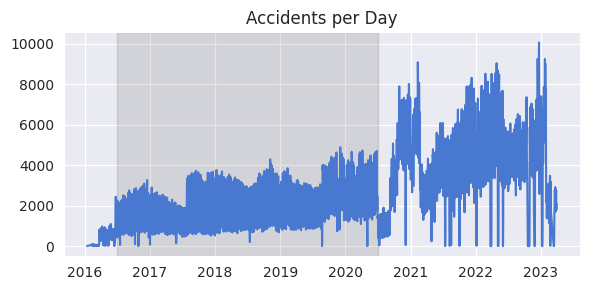

In [12]:
tmp = sedona.sql("""
    select count(*)                      as count,
           date_trunc('day', start_time) as date
    from accidents
    group by date;
""").toPandas().set_index("date")

fig, ax = plt.subplots(figsize=(6, 3))
sns.lineplot(tmp, legend=False, ax=ax)
ax.set(xlabel="", title="Accidents per Day");
ax.axvspan("2016-07-01", "2020-06-30", alpha=0.1, color="black");
plt.tight_layout()
plt.savefig("figures/accidents_per_day.png");

The data looks quite bad: collection didn't seem to begin consistantly until some time in mid 2016, and stopped dramatically in mid 2020. It starts again but looks unreliable beyond that point.  The shaded region above shows a period where the data looks ok. We will likely focus our analysis on these years.

### Weekend / Weekday Effect
The timeplot above looks very noisy, and one effec that could be expected is that people drive (and hence crash) less on the weekend.  The following code cell first captures the total number of crashes in the period of interest, then caclulates the proportion of crashes on each day of the week.

In other sql engines you could store the result of the first query as a variable. Spark SQL does not allow this, so we need to run two seperate queries and inject the result of the first. We could also write a nested query but it might be a bit hard to read.

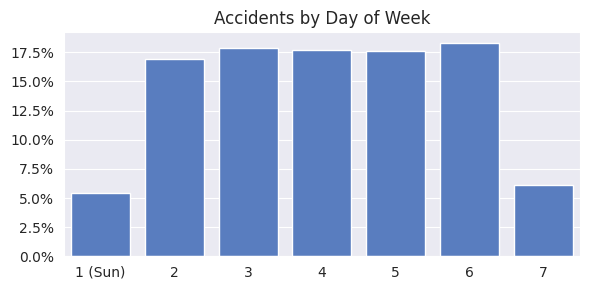

In [13]:
total_accidents = sedona.sql("""
select count(*)
from accidents
where start_time between "2016-07-01" and "2020-06-30";
""").first()[0]

tmp = sedona.sql(f"""
select count(*)                                     as count,
       round(count(*) / {total_accidents} * 100, 1) as proportion,
       extract(dow from start_time)                 as dow
from accidents
where start_time between "2016-07-01" and "2020-06-30"
group by dow
order by dow;
""").toPandas().set_index("dow")

fig, ax = plt.subplots(figsize=(6, 3))
sns.barplot(tmp, x="dow", y="proportion", ax=ax);
ax.set(xlabel="", ylabel="", title="Accidents by Day of Week");
ax.set_xticks([0, 1, 2, 3, 4, 5, 6]);
ax.set_xticklabels(['1 (Sun)', 2, 3, 4, 5, 6, 7]);
ax.yaxis.set_major_formatter('{x}%')
plt.tight_layout()
plt.savefig("figures/accidents_by_dow.png");

Clearly people do crash less on the weekend. 
Repeat the timeplot from above but only plot weekdays.

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


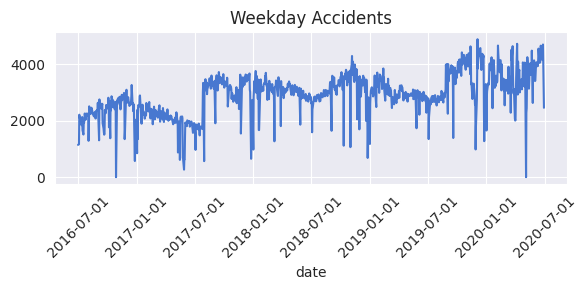

In [14]:
# Looks very noisy, maybe due to weekend/weekday effect.
# What if we only plot weekdays?

tmp = sedona.sql(
"""select count(*)                      as count,
           date_trunc('day', start_time) as date
    from accidents
    where start_time between "2016-07-01" and "2020-06-30"
        and extract(dow from start_time) between 2 and 6
    group by date;
""").toPandas().set_index("date")

fig, ax = plt.subplots(figsize=(6, 3))
sns.lineplot(tmp, legend=False, ax=ax, color='black')
# # Rotate x labels
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);
ax.set(title='Weekday Accidents')
plt.tight_layout()
plt.savefig("figures/weekday_accidents_per_day.png");
# The noisiness is still a bit offputting.

Something fishy going on with the large drops in accident count.

24/12/06 01:04:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/06 01:04:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/06 01:04:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/06 01:04:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/06 01:04:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/06 01:04:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/06 0

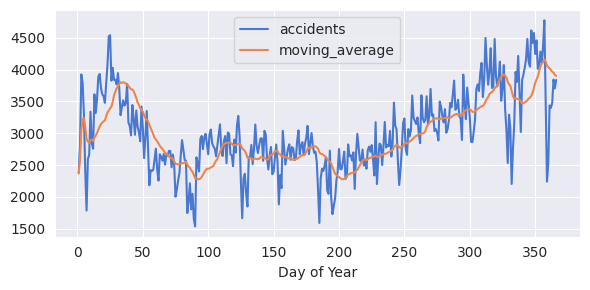

In [15]:
tmp = sedona.sql("""
select doy,
       accidents,
       avg(accidents) over (order by doy rows between 20 preceding and current row) as moving_average
from (select doy,
             avg(count) as accidents
      from (-- this query will select the number of accidents per day, for each day of the year and each year.
               select count(*)                     as count,
                      datepart('doy', start_time)  as doy,
                      datepart('year', start_time) as year
               from accidents
               group by doy, year)
      group by doy)
order by doy
""").toPandas().set_index("doy")

fig, ax = plt.subplots(figsize=(6, 3))
tmp.plot(ax=ax)
ax.set(xlabel="Day of Year")
plt.tight_layout()
plt.savefig("figures/accidents_and_moving_average.png");

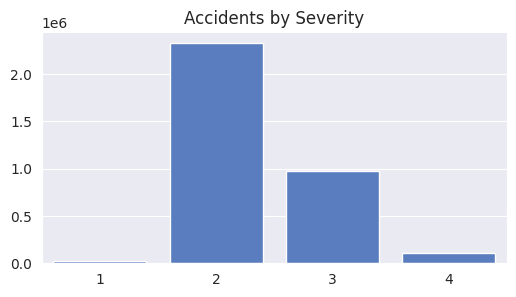

In [16]:
# Is the severity feature useful?
# Maybe not.

tmp = sedona.sql("""
select severity, 
       count(*) as count
from accidents
where start_time between "2016-07-01" and "2020-06-30"
group by severity
order by severity;
""").toPandas().set_index("severity")

fig, ax = plt.subplots(figsize=(6, 3))
sns.barplot(tmp, x="severity", y="count", ax=ax);
ax.set(xlabel="", ylabel="", title="Accidents by Severity");

## Geospatial Analysis
Time to combine the state/county shapefiles with the accidents data.

In [17]:
# Create a geo-dataframe (one with a geometry column) for accidents and simplify.

accidents_spatialDf = sedona.sql("""
select ST_Point(Start_Lng, Start_Lat) as geometry,
    Severity, 
    Start_Time,
    datepart('YEAR', Start_Time) as year,
    datepart('MONTH', Start_Time) as month,
    datepart('DOW', Start_Time) as dow,
    datepart('HOUR', Start_Time) as hour,
    Severity as severity,
    City as city,
    County as county,
    State as state_code
from accidents
""")
accidents_spatialDf.createOrReplaceTempView("accidents")

sedona.sql("select * from accidents limit 3").show()

+--------------------+--------+-------------------+----+-----+---+----+--------+------------+----------+----------+
|            geometry|Severity|         Start_Time|year|month|dow|hour|severity|        city|    county|state_code|
+--------------------+--------+-------------------+----+-----+---+----+--------+------------+----------+----------+
|POINT (-84.058723...|       3|2016-02-08 05:46:00|2016|    2|  2|   5|       3|      Dayton|Montgomery|        OH|
|POINT (-82.831184...|       2|2016-02-08 06:07:59|2016|    2|  2|   6|       2|Reynoldsburg|  Franklin|        OH|
|POINT (-84.032608...|       2|2016-02-08 06:49:27|2016|    2|  2|   6|       2|Williamsburg|  Clermont|        OH|
+--------------------+--------+-------------------+----+-----+---+----+--------+------------+----------+----------+



In [18]:
# Accidents per county in Texas.
tmp = sedona.sql("""
 select c.geometry,
    c.name as county,
    ifnull(a.count, 0) as accidents
from counties c
left outer join (
    select count(*) as count,
        county
    from accidents a
    where a.state_code = 'TX'
        and start_time between "2016-07-01" and "2020-06-30"
    group by a.county) a
on c.name = a.county
where c.STUSPS = 'TX'
order by accidents desc;
""")

tmp.show(10)

+--------------------+----------+---------+
|            geometry|    county|accidents|
+--------------------+----------+---------+
|MULTIPOLYGON (((-...|    Harris|   106975|
|POLYGON ((-97.038...|    Dallas|    75659|
|POLYGON ((-98.159...|    Travis|    68672|
|POLYGON ((-98.806...|     Bexar|    24706|
|POLYGON ((-97.550...|   Tarrant|    17456|
|POLYGON ((-106.64...|   El Paso|    11501|
|POLYGON ((-98.049...|Williamson|     3841|
|POLYGON ((-96.844...|    Collin|     3022|
|POLYGON ((-97.398...|    Denton|     2596|
|POLYGON ((-95.830...|Montgomery|     1484|
+--------------------+----------+---------+
only showing top 10 rows



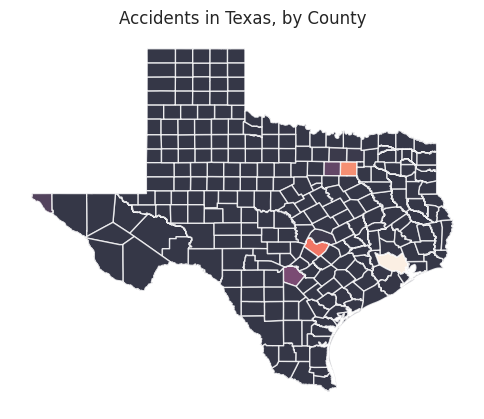

In [19]:
# Choropleth plot.
fig, ax = plt.subplots()
ax.axis('off')

gpd.GeoDataFrame(tmp.toPandas(), geometry="geometry").plot(ax=ax, column='accidents', alpha=.8);
ax.set(title="Accidents in Texas, by County");

In [20]:
# It would be nice to make a fancy map with PyDeck but it's alittle bit painful 
# and is a distraction from the main purpose here.
if False:
    deck = spdk.create_geometry_map(tmp)

    tooltip = {
        "html": "<b>County:</b> {county} <br/> <b>Accidents:</b> {accidents}",
        "style": {
                "backgroundColor": "steelblue",
                "color": "white"
        }
    }

    pdk.Deck(
        layers=deck.layers,
        initial_view_state=deck.initial_view_state,
        tooltip=tooltip,
        map_style='light'
    )

+--------------------+---------+---------+----------+-------+
|            geometry|   county|accidents|population| Ap100k|
+--------------------+---------+---------+----------+-------+
|POLYGON ((-98.159...|   Travis|    68672|   1121.6k|6122.44|
|POLYGON ((-98.806...|    Bexar|    24706|   1825.5k|1353.38|
|MULTIPOLYGON (((-...|   Harris|   106975|   8712.7k| 1227.8|
|POLYGON ((-97.550...|  Tarrant|    17456|   1914.5k| 911.77|
|POLYGON ((-103.98...|   Loving|        1|      0.1k|  854.7|
|POLYGON ((-104.91...|Culberson|       17|      2.3k| 740.42|
|POLYGON ((-100.11...|   Kimble|       33|      4.5k| 735.62|
|POLYGON ((-105.99...| Hudspeth|       24|      3.3k| 720.72|
|POLYGON ((-106.64...|  El Paso|    11501|   1662.2k| 691.92|
|POLYGON ((-96.518...| Rockwall|      554|     85.5k| 647.68|
+--------------------+---------+---------+----------+-------+
only showing top 10 rows



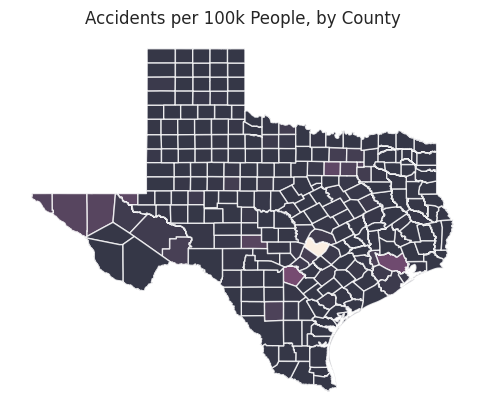

In [21]:
# As above but normalised by population.
tmp = sedona.sql("""
 select c.geometry,
    c.name as county,
    ifnull(a.count, 0) as accidents,
    cast(round(cencus.population / 1000, 1) as string) || "k" as population,
    round(accidents / cencus.population * 100000, 2) as Ap100k
from counties c
left outer join (
    select count(*) as count,
        county
    from accidents a
    where a.state_code = 'TX'
        and start_time between "2016-07-01" and "2020-06-30"
    group by a.county) a
on c.name = a.county
right outer join (
    select County, 
        sum(TotalPop) as population 
    from cencus
    left outer join counties c
        on County = c.name
    where State = 'Texas'
    group by County 
) cencus
on c.name = cencus.County
where c.STUSPS = 'TX'
order by Ap100k desc
""")

tmp.show(10)

fig, ax = plt.subplots()
ax.axis('off')
gpd.GeoDataFrame(tmp.toPandas(), geometry="geometry").plot(ax=ax, column='Ap100k', alpha=.8);
ax.set(title="Accidents per 100k People, by County");

In [22]:
md = tmp.toPandas().head(4)
md['geometry'] = '...'
print(md.to_markdown())

|    | geometry   | county   |   accidents | population   |   Ap100k |
|---:|:-----------|:---------|------------:|:-------------|---------:|
|  0 | ...        | Travis   |       68672 | 1121.6k      |  6122.44 |
|  1 | ...        | Bexar    |       24706 | 1825.5k      |  1353.38 |
|  2 | ...        | Harris   |      106975 | 8712.7k      |  1227.8  |
|  3 | ...        | Tarrant  |       17456 | 1914.5k      |   911.77 |


+--------------------+--------------+
|                name|    state_name|
+--------------------+--------------+
|Fairbanks North Star|        Alaska|
| Southeast Fairbanks|        Alaska|
|            Honolulu|        Hawaii|
|               Kauai|        Hawaii|
|             Eastern|American Samoa|
+--------------------+--------------+
only showing top 5 rows



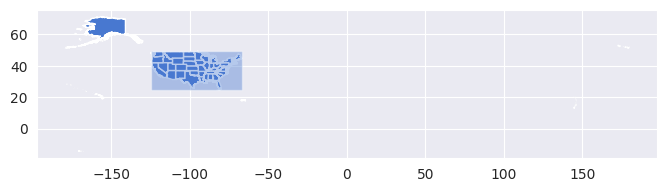

In [23]:
# Find a bounding box for the contiguous US

fig, ax = plt.subplots(figsize=(8,8))
gpd.GeoDataFrame(sedona.sql("select * from states").toPandas()).set_crs(4326).plot(ax=ax)
# Geometry functions expect coordinates in Long/Lat order.
gpd.GeoDataFrame(sedona.sql("""
SELECT ST_PolygonFromText('-124.7844079,24.7433195,-124.7844079,49.3457868,-66.9513812,49.3457868,-66.9513812,24.7433195,-124.7844079,24.7433195', ',') as geometry
""").toPandas()).plot(ax=ax, alpha=.4)

# Counties outside the box.
sedona.sql("""
    select name,
        state_name 
    from counties
    where not ST_Contains(
        ST_PolygonFromText('-124.7844079,24.7433195,-124.7844079,49.3457868,-66.9513812,49.3457868,-66.9513812,24.7433195,-124.7844079,24.7433195', ','),
        geometry
    )
""").show(5)